In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pickle

In [2]:
FIGSIZE = (14,8)

In [3]:
with open('..//data//simulated_covar_matrices.pkl', 'rb') as f:
    covar_matrices = pickle.load(f)

In [4]:
len(covar_matrices)

101

In [5]:
# not correct calculation i think! useful for now:

# 252 days is found in another notebook

def calc_risk_free_rate(annual_rate = 0.02, days=252):
    return np.exp(np.log(1 + annual_rate) / days) - 1
    
rf = calc_risk_free_rate()

In [6]:
def sample_means(n=11):
    # found from maximum likelihood estimation
    mu, sigma = 0.001231415380377799, 0.0004612333818775558
    return np.random.normal(mu, sigma, size=n)

In [7]:
def calc_tangency_portfolio(mu, covars, rf):
    ones, covars_inv = np.ones(len(means)), np.linalg.inv(covars)

    risk_adjusted_mu = (mu - (rf * ones))
    
    numer = np.dot(covars_inv, risk_adjusted_mu)
    denom = np.dot(ones.T, numer)
    return numer / denom
    

In [8]:
means = sample_means()
calc_tangency_portfolio(means, covar_matrices[0], rf)

array([ 0.12877894,  0.00868297, -0.04981709, -0.0728749 ,  0.02710714,
        1.58907782, -0.48958794,  0.0259442 ,  0.03839993, -0.00960505,
       -0.19610603])

In [9]:
means = sample_means()

In [10]:
covar_matrices[0]

array([[ 5.64221933e-05,  1.48006557e-05,  6.24555804e-05,
         2.24659199e-05,  2.06103604e-05, -8.93151548e-07,
         4.78424636e-06,  4.26599221e-05,  2.61484058e-05,
         1.74211917e-05,  5.93394999e-06],
       [ 1.48006557e-05,  8.87213376e-04,  1.86116354e-04,
         1.63700884e-04,  1.99265538e-04,  9.48831855e-06,
         1.76697078e-05,  2.25489027e-04,  1.25119440e-04,
         2.11106063e-05,  5.35749531e-05],
       [ 6.24555804e-05,  1.86116354e-04,  3.32968932e-04,
         3.52650219e-05,  5.59228787e-05,  3.48699467e-06,
        -3.14079770e-06,  1.02849467e-04,  5.53962226e-05,
        -2.71440620e-06,  1.90116422e-05],
       [ 2.24659199e-05,  1.63700884e-04,  3.52650219e-05,
         2.30901385e-04,  4.68779975e-05,  7.52710507e-06,
         7.82810580e-06,  6.32486550e-05,  1.28027497e-04,
         1.19961554e-04,  1.14848746e-06],
       [ 2.06103604e-05,  1.99265538e-04,  5.59228787e-05,
         4.68779975e-05,  1.15599514e-04,  3.77277452e-06,
  

In [11]:
cm = covar_matrices[0]

In [12]:
#https://math.stackexchange.com/questions/268298/sampling-from-a-2d-normal-with-a-given-covariance-matrix#268301 (explanation)


In [33]:
class SimulateDatasets():
    """
    Parameters
    ==========
    covar_matrices : list of covar_matrices
    struct_break_prob : probability of structural break
    
    """
    
    @staticmethod
    def _sample_list_of_means(number_of_entries, n=11):
        """number_of_entries * n"""
        
        return [sample_means(n) for _ in range(number_of_entries)]
        
    def __init__(self, covar_matrices, struct_break_prob, risk_free_rate, dataset_length=1000):
        n_vars, n_sims = len(covar_matrices[0]), len(covar_matrices)
        self.n_vars = n_vars
        self.n_sims = n_sims
        self.risk_free_rate = risk_free_rate
        self.struct_break_prob = struct_break_prob
        self.covar_matrices = covar_matrices
        self.expected_returns = self._sample_list_of_means(n_sims, n_vars)
        self.dataset_length = dataset_length
        
        self.sim_number = 0
        
        
    @staticmethod
    def sample_returns(covar_matrix):
        """

        Lower triangle matrix L (from cholesky) implies: L * x, where x is random variates. 
        """
        size = len(covar_matrix)
        return np.dot(np.linalg.cholesky(covar_matrix), np.random.normal(size=size)) 
        
    def sample_return(self):
        means, covars = self.expected_returns[self.sim_number], self.covar_matrices[self.sim_number] 
        return self.sample_returns(covars) + means
        
    def sample_dataset(self):
        sim_length = self.dataset_length
            
        returns = np.empty(shape=(self.n_vars, sim_length))
        structural_breaks = list()
        tangency_portfolios = np.empty(shape=(self.n_vars, sim_length))
        
        _mu, _covars = self.expected_returns[self.sim_number], self.covar_matrices[self.sim_number]
        tp = calc_tangency_portfolio(_mu, _covars, self.risk_free_rate)
        
        for i in range(sim_length):
            
            structural_break = int(np.random.binomial(1, self.struct_break_prob, 1))
            if structural_break == 1:
                structural_breaks.append(i)
                
                self.sim_number = self.sim_number + 1
                
                _mu, _covars = self.expected_returns[self.sim_number], self.covar_matrices[self.sim_number]
                tp = calc_tangency_portfolio(_mu, _covars, self.risk_free_rate)
            
            r = self.sample_return()
            
            returns[:,i] = r
            tangency_portfolios[:,i] = tp 
            
        return returns, tangency_portfolios, structural_breaks

In [37]:
prob_struct_break = 0.001

for i in range(100):
    sd = SimulateDatasets(covar_matrices, prob_struct_break, rf)
    l, tps, breaks = sd.sample_dataset()

In [40]:
def gen_names():
    [f"w{ix}" for ix in range(l.shape[0]) ]
    for i in range(l.shape[0]):
        []

11

In [17]:
k = pd.DataFrame(l.T)

In [18]:
h = pd.DataFrame(tps.T)

In [19]:
sd.sim_number

10

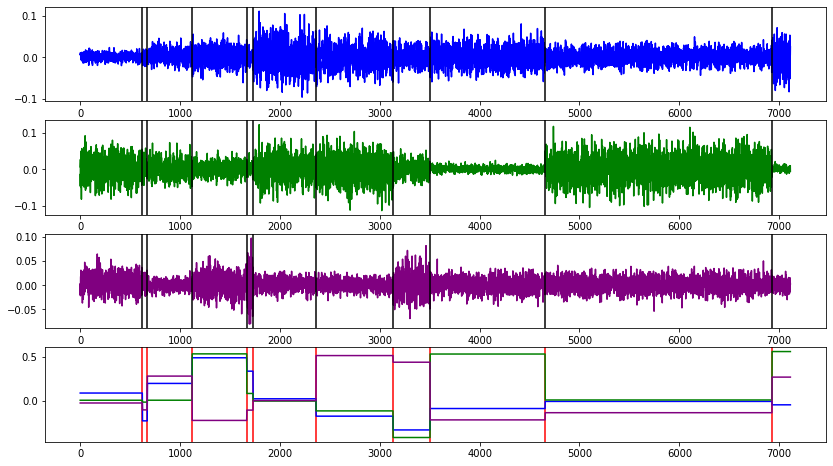

In [28]:
f, (ax1, ax2, ax3, axb) = plt.subplots(4,1, figsize=FIGSIZE)
ax1.plot(k[0], color='blue')
ax2.plot(k[1], color='green')
ax3.plot(k[2], color='purple')

for b in breaks:
    ax1.axvline(b, color='black')
    ax2.axvline(b, color='black')
    ax3.axvline(b, color='black')

    axb.axvline(b, color='red')

axb.plot(h[0], color='blue')
axb.plot(h[1], color='green')
axb.plot(h[2], color='purple')




## Looking at returns

### Article deriving the efficient portfolio Frontier

Merton, Robert, 1972, An Analytic Derivation of the Efficient Portfolio Frontier, Journal of Financial and Quantitative Analysis